# Real or Not? NLP with Disaster Tweets

This is my work for Kaggle competition. This particular challenge is perfect for data scientists looking to get started with Natural Language Processing.

Link: https://www.kaggle.com/c/nlp-getting-started

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In this notebook we will use word2vec model and feature engineering. Predicting model is simple Logistic Regression.

## 1 - Packages

In [1]:
import pandas as pd 
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.patches as mpatches
from nltk import word_tokenize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2 - Overview of the Dataset

Loading data:

In [2]:
train_data = pd.read_csv("train.csv", header=0, delimiter=",")
test_data = pd.read_csv("test.csv", header=0, delimiter=",")

Shape of datasets:

In [3]:
print('Shape of train data: ', train_data.shape)
print('Shape of test data: ', test_data.shape)

Shape of train data:  (7613, 5)
Shape of test data:  (3263, 4)


First 5 rows of train data dataset:

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Review text fields:

In [5]:
train_data.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

Inspecting number of sentences in each class of training set.

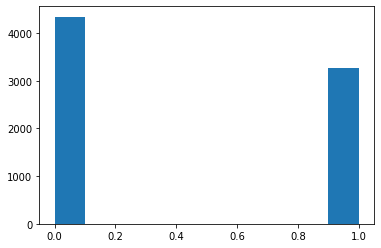

1 class percentage in train set 0.4296597924602653


In [31]:
plt.hist(train_data.target)
plt.show()

percentage = train_data.target.sum()/train_data.target.count()
print('1 class percentage in train set', percentage)

## 3 - Feature extraction 

### Using CountVectorizer and TfidfTransformer

Extract text of tweets in train and data sets. Concatenate them into corpus to use as vocabulary in CountVectorizer.

In [6]:
train_corpus = train_data.text
train_labels = train_data.target

test_corpus = test_data.text

corpus = pd.concat([train_corpus, test_corpus])

Creating pipeline for feature extracting. Transform train and test sets into sparse matrixes of counts followed by TF-IDF transformation. 

(TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.)

In [7]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer())
                ])

pipe.fit(corpus)
print('Vocabulary lenght is', len(pipe['vect'].vocabulary_), 'words.')

processed_train_corpus = pipe.transform(train_corpus)
processed_test_corpus = pipe.transform(test_corpus)

Vocabulary lenght is 27922 words.


Let's use super simple LogisticRegression() model. It's cross-validation results for features extracted using CountVectorizer and TfidfTransformer:

In [8]:
cv_results = cross_validate(LogisticRegression(), processed_train_corpus, train_labels, cv=5)
cv_results['test_score'].mean()

C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7363743219767018

The result accuracy is 0.74. This is not high score but it works better than constant classifier.

Create function for plotting embeddings using LCA (Latent semantic analysis). We are projecting 27922 dimesnions to 2.

In [9]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 15})

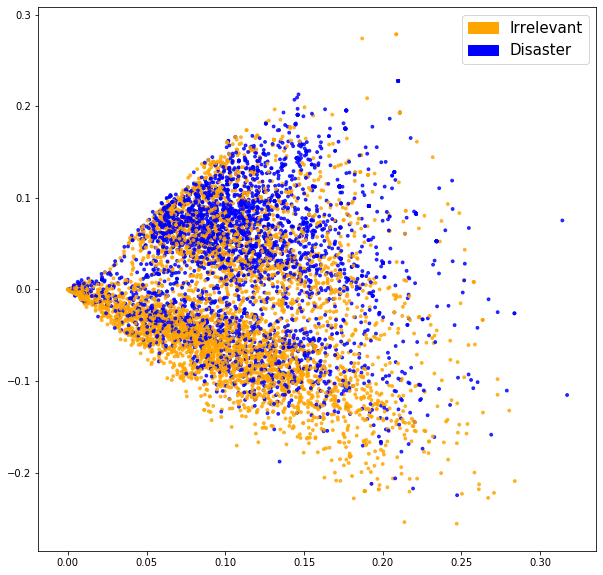

In [10]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(processed_train_corpus, train_labels)
plt.show()

We can see that classes are not really separable.

### Word2Vec

Word2vec is a group of related models that are used to produce word embeddings. Gensim is an open-source library for unsupervised topic modeling and natural language processing.

GloVe: Global Vectors provides Pre-trained word vectors. The model weights around 800Mb. It is trained on Wikipedia 2014 + Gigaword 5.

Link: https://nlp.stanford.edu/projects/glove/#discuss

In [12]:
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_path = "glove.6B/glove.6B.100d.txt"
glove2word2vec(glove_input_file=word2vec_path, word2vec_output_file="glove.6B/gensim_glove_vectors.txt")

from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("glove.6B/gensim_glove_vectors.txt", binary=False)

Let's see some examples of most_similar method for the model.

In [13]:
glove_model.wv.most_similar(positive=["best"])

C:\Users\Kate\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('good', 0.8052446842193604),
 ('well', 0.7833639979362488),
 ('better', 0.7770284414291382),
 ('winning', 0.7673192024230957),
 ('one', 0.7539506554603577),
 ('performance', 0.7355164289474487),
 ('success', 0.7354246973991394),
 ('ever', 0.7291375994682312),
 ('excellent', 0.7287570238113403),
 ('play', 0.727339506149292)]

In [14]:
glove_model.wv.most_similar(positive=["cat"])

C:\Users\Kate\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('dog', 0.8798074722290039),
 ('rabbit', 0.7424427270889282),
 ('cats', 0.7323004007339478),
 ('monkey', 0.7288710474967957),
 ('pet', 0.7190139293670654),
 ('dogs', 0.7163873314857483),
 ('mouse', 0.6915251016616821),
 ('puppy', 0.6800068616867065),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501134634017944)]

Wow, that works!

In [32]:
tokenized_train_corpus = [word_tokenize(sent) for sent in train_corpus]
tokenized_test_corpus = [word_tokenize(sent) for sent in test_corpus]

In [16]:
def get_average_word2vec(tokens_list, vectors, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vectors[word] if word in vectors else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vectors[word] if word in vectors else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

embeddings_train_corpus = get_word2vec_embeddings(glove_model, train_corpus)
print('Check length of resulted list of embeddings', len(embeddings_train_corpus))

Check length of resulted list of embeddings 7613


Implementing Logistic Regression model for new embeddings.

In [17]:
cv_results = cross_validate(LogisticRegression(), embeddings_train_corpus, train_labels, cv=5)
cv_results['test_score'].mean()

C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Kate\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

0.6528304345650796

The result is even lower than previous despite using external vector embeddings.

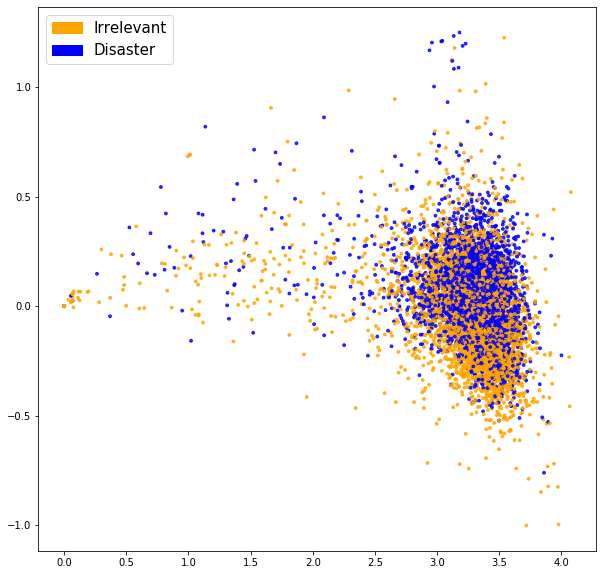

In [18]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings_train_corpus, train_labels)
plt.show()

We can see that classes became less separable.

## 4 - Predicting

In [37]:
clf = LogisticRegression()
clf.fit(processed_train_corpus, train_labels)
results = clf.predict(processed_test_corpus)

In [39]:
submission = pd.DataFrame({'id': test_data.id, 'target': results})
submission.to_csv('submission.csv', index=False)